# 0.0 Imports

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt
import pickle
import os

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from matplotlib      import pyplot          as plt
from sklearn         import preprocessing   as pp
from sklearn         import model_selection as ms
from sklearn         import ensemble        as en
from sklearn         import neighbors       as nh
from sklearn         import linear_model    as lm


# 0.1 Loading Dataset

In [2]:
df_raw = pd.read_csv( 'data/insurance_data.csv' ).sort_values( by = 'id' )
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
143003,1,Male,44,28.0,26.0,0,40454.0,217,1,1,> 2 Years,Yes
286227,2,Male,76,3.0,26.0,0,33536.0,183,0,1,1-2 Year,No
143004,3,Male,47,28.0,26.0,0,38294.0,27,1,1,> 2 Years,Yes
190848,4,Male,21,11.0,152.0,1,28619.0,203,0,1,< 1 Year,No
238464,5,Female,29,41.0,152.0,1,27496.0,39,0,1,< 1 Year,No


# 1.0 Data Description

* <b>id:</b> Identificador único para cada cliente ou entrada no DataFrame. Geralmente é um número sequencial que não contém informações significativas além de servir como chave primária.


* <b>gender:</b> Categoria de gênero do cliente. Esta coluna contém os valores  'Male', 'Female'


* <b>age:</b> Idade do cliente em anos. Esta é uma variável quantitativa que indica a idade do cliente.


* <b>region_code:</b> Código numérico que representa uma área geográfica específica, como um estado ou região. Os códigos são únicos para cada área e são usados para agrupar clientes por localização geográfica.


* <b>policy_sales_channel:</b> Código numérico que representa o canal de vendas através do qual a política de seguro foi adquirida. Por exemplo, isso pode indicar se a política foi comprada online, através de um agente, por telefone, etc.


* <b>previously_insured:</b> Indica se o cliente já tinha um seguro antes de adquirir este (1 para sim e 0 para não). Esta é uma variável binária/indicadora.


* <b>annual_premium:</b> Valor do prêmio do seguro que o cliente precisa pagar anualmente. É uma variável contínua que representa quanto o cliente gasta com o seguro por ano.


* <b>vintage:</b> O número de dias que o cliente tem estado associado com a companhia de seguros. Isso poderia indicar a duração do relacionamento do cliente com a seguradora.


* <b>response:</b> Indica se o cliente respondeu positivamente (1) ou não (0) a uma oferta de seguro. É a variável resposta que queremos prever.


* <b>driving_license:</b> Mostra se o cliente possui ou não uma carteira de motorista (1 para sim e 0 para não). Outra variável binária/indicadora.


* <b>vehicle_age:</b> Categoria que indica a idade do veículo do cliente. Pode ser representada em faixas, como '0-2 anos', '2-4 anos', 'mais de 4 anos', etc.


* <b>vehicle_damage:</b> Indica se o veículo do cliente sofreu algum dano no passado (com 'Sim' para dano e 'Não' para nenhum dano). Isso pode ser relevante para avaliar o risco e a propensão para adquirir um seguro.


In [3]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [4]:
print( 'Numbers of rows {}'.format( df1.shape[0] ) )
print( 'Numbers of columns {}'.format( df1.shape[1] ) )

Numbers of rows 381109
Numbers of columns 12


## 1.2 Data Types

In [5]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3 Check NA


In [6]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4 Data Descriptive

In [7]:
# separo em categoricos e numéricos
num_attributes = df1.select_dtypes( include = ['int64', 'float64']  )
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

In [8]:
def data_descriptive( df ):
    # Central tendency - mean, median
    ct1 = pd.DataFrame( df.apply( np.mean ) ).T # calculado a media das colunas -- aplica em todas colunas
    ct2 = pd.DataFrame( df.apply( np.median) ).T # calculando a mediana

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( df.apply( np.std ) ).T # calculando o std 
    d2 = pd.DataFrame( df.apply( np.min ) ).T # calculando o min
    d3 = pd.DataFrame( df.apply( np.max ) ).T # calculando o max
    d4 = pd.DataFrame( df.apply( lambda x: x.max() - x.min()  ) ).T # calcula o range
    d5 = pd.DataFrame( df.apply( lambda x: x.skew() ) ).T # calcula o skew
    d6 = pd.DataFrame( df.apply( lambda x: x.kurtosis() ) ).T # calcula o kurtosis

    # concatenate
    m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
    m.columns = ['features','min','max','range','mean','median','std','skew','kurtosis'] 
    return m

In [9]:
data_descriptive( num_attributes )

,features,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


# 2.0 Feature Engineering

In [10]:
df2 = df1.copy()

In [11]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                        if x == '1-2 Year' else 'below_1_year')
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x : 1 if x == 'Yes' else 0 )
df2.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
143003,1,Male,44,28.0,26.0,0,40454.0,217,1,1,over_2_years,1
286227,2,Male,76,3.0,26.0,0,33536.0,183,0,1,between_1_2_years,0
143004,3,Male,47,28.0,26.0,0,38294.0,27,1,1,over_2_years,1
190848,4,Male,21,11.0,152.0,1,28619.0,203,0,1,below_1_year,0
238464,5,Female,29,41.0,152.0,1,27496.0,39,0,1,below_1_year,0


# 3.0 Data Filtering

In [12]:
df3 = df2.copy()

# 4.0 EDA

In [13]:
df4 = df3.copy()

## 4.1 Univariate Analysis

Pela mediana pessoas mais velhas tem mais interesse em comprar o seguro.


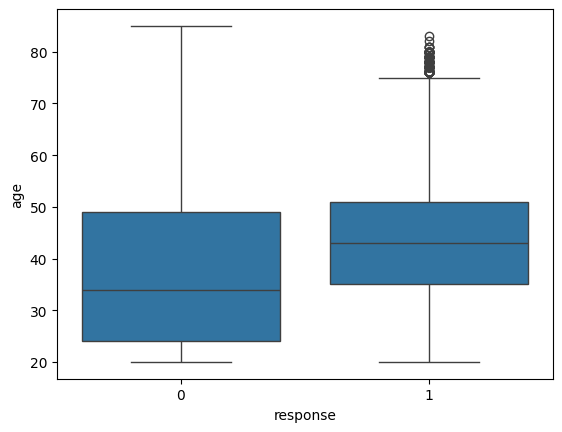

In [14]:
# age - vejo como está o comportamento baseado na idade
sns.boxplot( x = 'response', y = 'age', data = df4 )

print( 'Pela mediana pessoas mais velhas tem mais interesse em comprar o seguro.' )

<Axes: xlabel='age', ylabel='Count'>

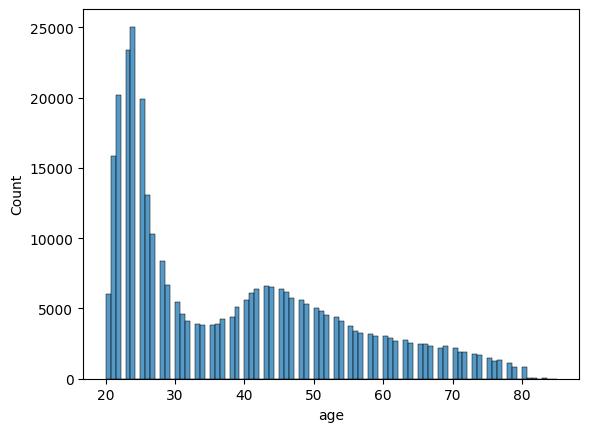

In [15]:
# pessoas que não tem interesse em comprar seguro
aux00 = df4.loc[ df4['response'] == 0 , 'age']
sns.histplot( aux00 )

<Axes: xlabel='age', ylabel='Count'>

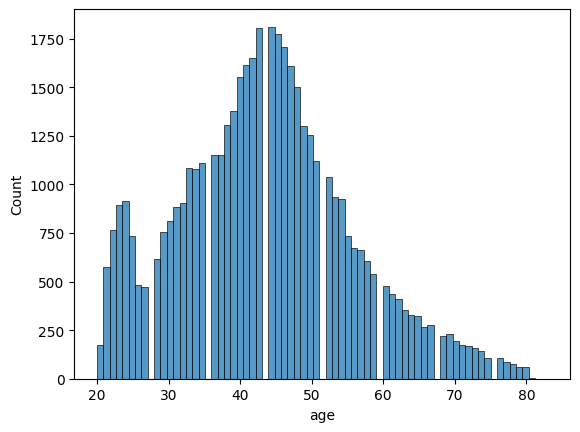

In [16]:
# pessoas que tem interesse em comprar seguro
aux00 = df4.loc[ df4['response'] == 1 , 'age']
sns.histplot( aux00 )

#### Analisando a distribuição, percebo que a <b>classe 0</b> - não interessado - tem uma representatividade maior (25.000) que a de interesados <b>classe 1</b> (1.750).

<Axes: xlabel='response', ylabel='annual_premium'>

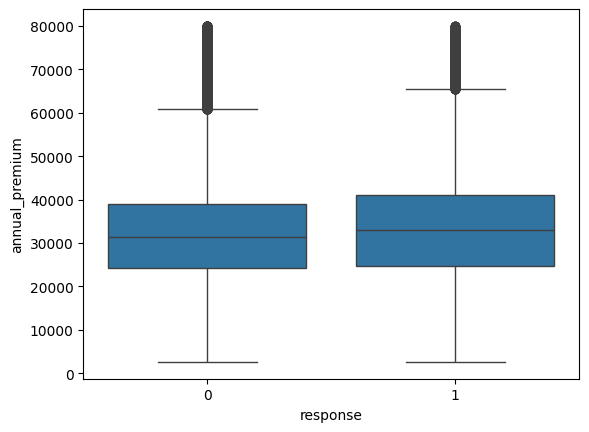

In [17]:
# annual_premium 
df_aux = df4.loc[ df4['annual_premium'] < 80000, : ]
sns.boxplot( x = 'response', y = 'annual_premium', data = df_aux  )

<Axes: xlabel='annual_premium', ylabel='Count'>

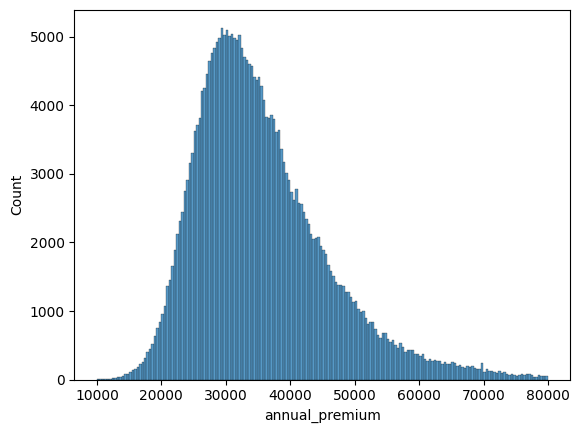

In [18]:
# verifico a distribuição
df_aux = df4.loc[ (df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000), : ]
aux00 = df_aux.loc[ df4['response'] == 0 , 'annual_premium']
sns.histplot( aux00 )

<Axes: xlabel='annual_premium', ylabel='Count'>

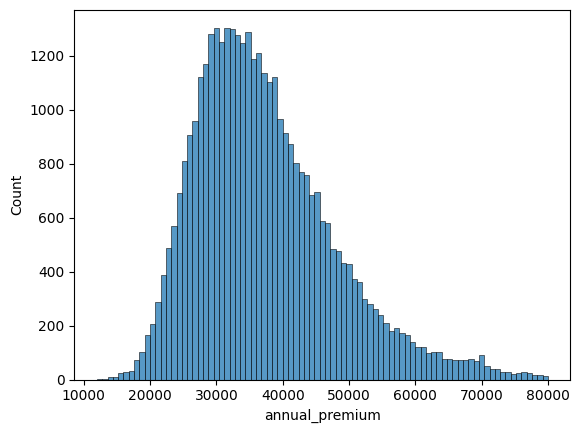

In [19]:
# verifico a distribuição
aux00 = df_aux.loc[ df4['response'] == 1 , 'annual_premium']
sns.histplot( aux00 )

<Axes: xlabel='response', ylabel='driving_license'>

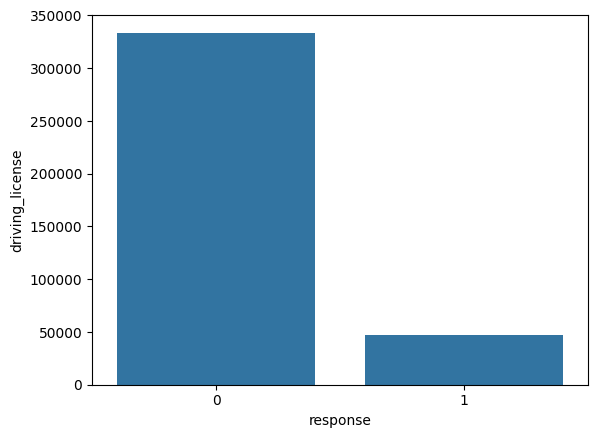

In [20]:
# driving_license
aux = df4[[ 'driving_license', 'response' ]].groupby( by = 'response' ).sum().reset_index()
sns.barplot( x = 'response', y = 'driving_license', data = aux )

In [21]:
# driving_license em %
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum() 
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='region_code', ylabel='id'>

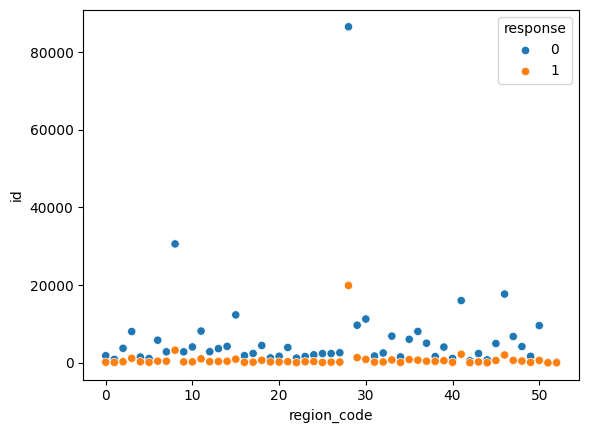

In [22]:
# region_code
aux0 = df4[['id','region_code','response']].groupby( by = ['region_code','response'] ).count().reset_index()
sns.scatterplot( x = 'region_code', y = 'id', hue = 'response', data = aux0 )

In [23]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis = 1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [24]:
# vehicle_age
df4[['vehicle_age','response']].value_counts( normalize = True ).reset_index().sort_values(by = 'vehicle_age' )

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


<Axes: xlabel='response', ylabel='policy_sales_channel'>

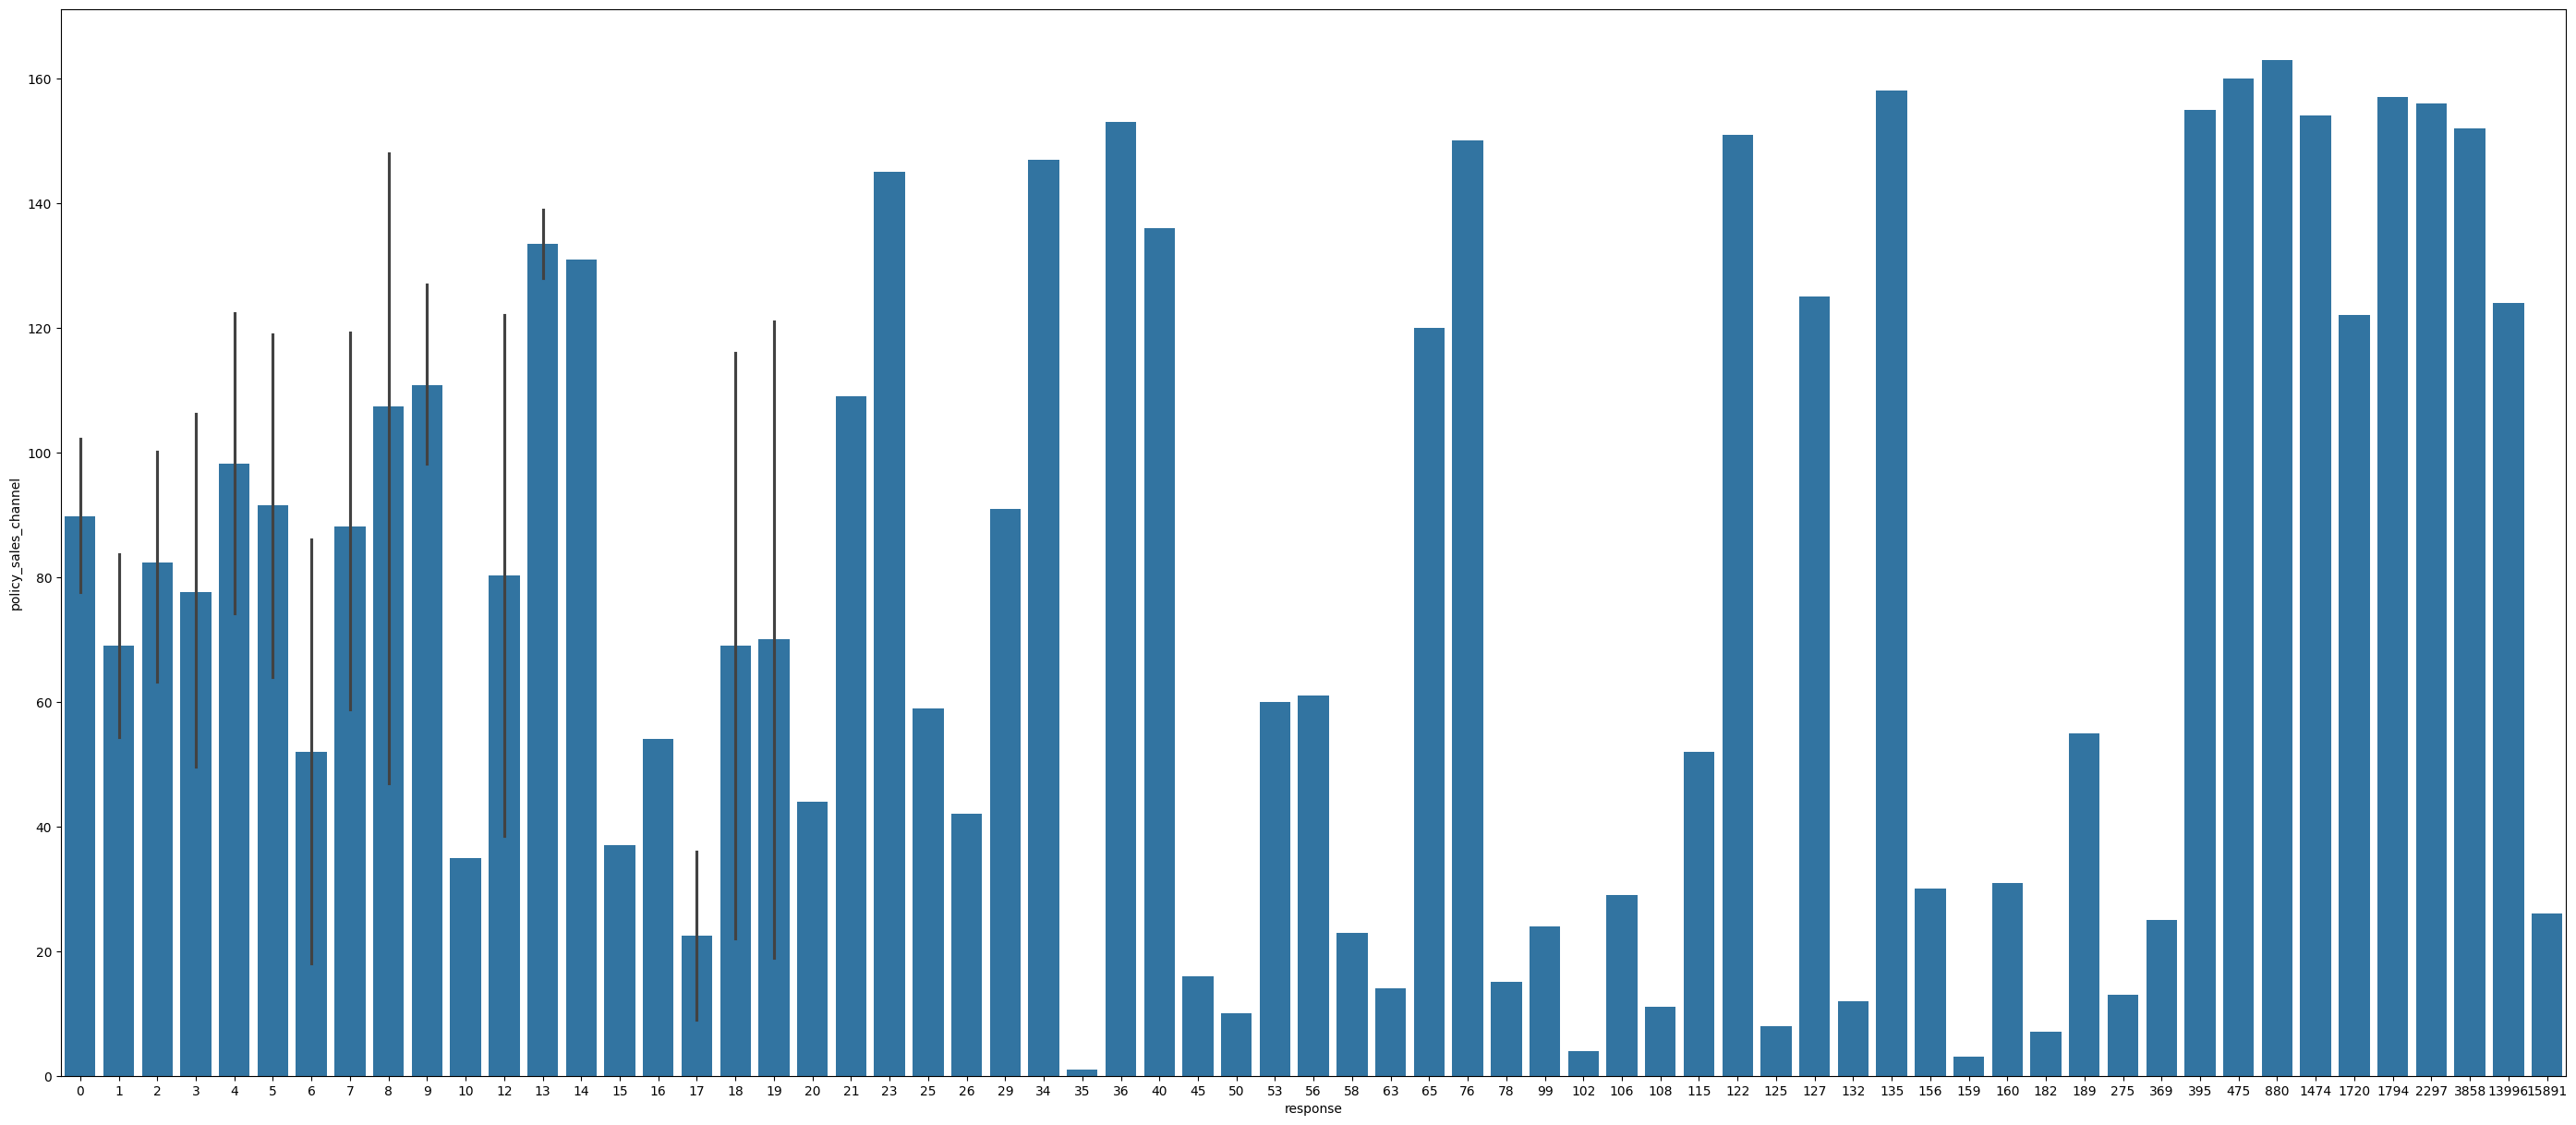

In [25]:
# policy_sales_channel
plt.figure( figsize = (35,15) )
aux = df4[['policy_sales_channel','response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x = 'response', y = 'policy_sales_channel', data = aux )

<Axes: xlabel='response', ylabel='vintage'>

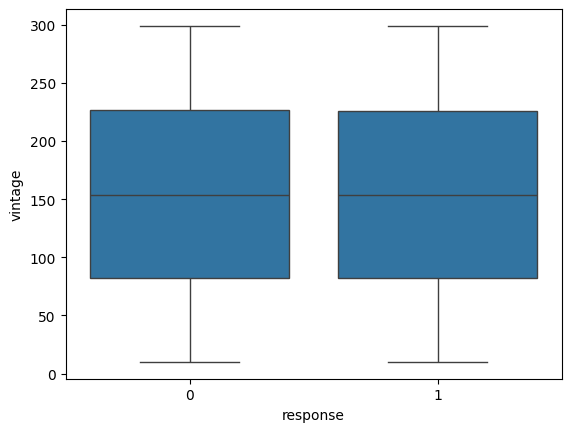

In [26]:
# vintage
sns.boxplot( x = 'response', y = 'vintage', data = df4 )

<Axes: xlabel='vintage', ylabel='Count'>

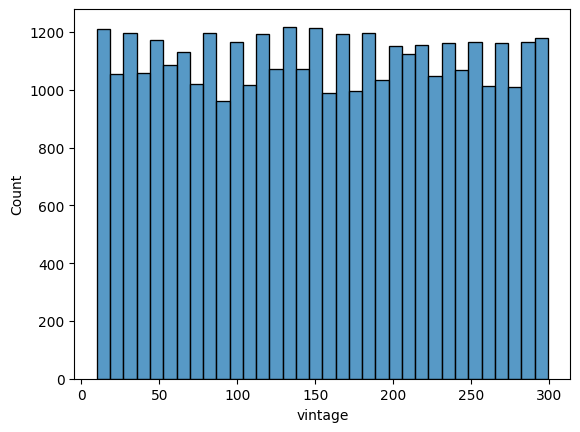

In [27]:
aux00 = df_aux.loc[ df4['response'] == 1 , 'vintage']
sns.histplot( aux00 )

<Axes: xlabel='vintage', ylabel='Count'>

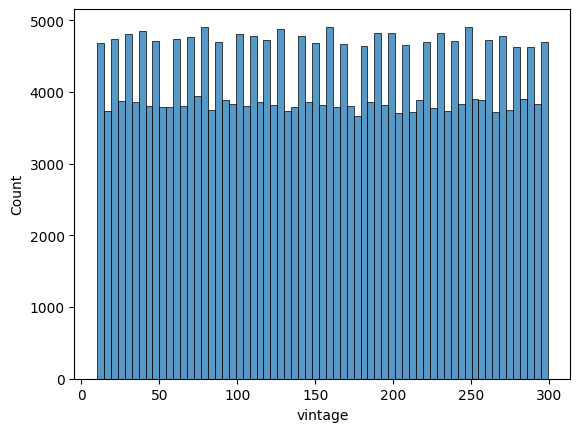

In [28]:
aux00 = df_aux.loc[ df4['response'] == 0 , 'vintage']
sns.histplot( aux00 )

# 5.0 Data Preparation

In [29]:
df5 = df4.copy()

In [30]:
# treino
X = df5.drop( 'response', axis = 1 )
# teste
y = df5['response'].copy()

# separa treino e teste
x_train, x_test, y_train, y_test = ms.train_test_split( X, y , test_size = 0.3 )

print( f'Total shape {df5.shape}' )

print( '='*50 )

print( f'xtrain shape: {x_train.shape}' )
print( f'y train shape:  {y_train.shape}' )

print( '='*50 )

print( f'xtrain shape {x_test.shape}' )
print( f'y test {y_test.shape}')



Total shape (381109, 12)
xtrain shape: (266776, 11)
y train shape:  (266776,)
xtrain shape (114333, 11)
y test (114333,)


In [31]:
# df treino
df5_train = pd.concat( [x_train,y_train] ,  axis = 1 )

In [32]:
# df treino
df5_test = pd.concat( [x_test,y_test ] , axis = 1 )

In [33]:
df5_stats = df5_train.select_dtypes( include = ['int64', 'float64'] )
data_descriptive( df5_stats )

,features,min,max,range,mean,median,std,skew,kurtosis
0,id,2.0,381109.0,381107.0,190435.859290,190455.5,110028.897443,0.001415,-1.201125
1,age,20.0,85.0,65.0,38.819283,36.0,15.503666,0.671827,-0.565060
2,region_code,0.0,52.0,52.0,26.404568,28.0,13.229338,-0.117056,-0.865826
3,policy_sales_channel,1.0,163.0,162.0,111.999929,136.0,54.238016,-0.898224,-0.974944
4,previously_insured,0.0,1.0,1.0,0.458617,0.0,0.498285,0.166103,-1.972425
5,annual_premium,2630.0,540165.0,537535.0,30521.553359,31645.5,17171.839077,1.736212,34.354648
6,vintage,10.0,299.0,289.0,154.249127,154.0,83.699111,0.003804,-1.201278
7,driving_license,0.0,1.0,1.0,0.997871,1.0,0.046093,-21.602857,464.686922
8,vehicle_damage,0.0,1.0,1.0,0.504371,1.0,0.499981,-0.017484,-1.999709
9,response,0.0,1.0,1.0,0.122260,0.0,0.327586,2.306219,3.318673


## Standardization

In [34]:
# instancia o ss
ss = pp.StandardScaler()
# annual_premium - aplico pois o range é muito amplo
df5_train['annual_premium'] = ss.fit_transform(df5_train[['annual_premium']].values)
pickle.dump( ss, open( r'\Users\oscar\Documents\repos\pa004\features_transformation\annual_premium_scaler.pkl', 'wb' ) )

## Rescaling

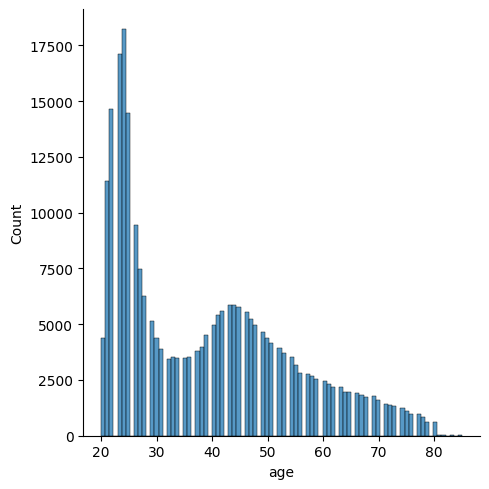

In [35]:
# distribuição age
sns.displot( df5_train['age'] )

<Axes: ylabel='vintage'>

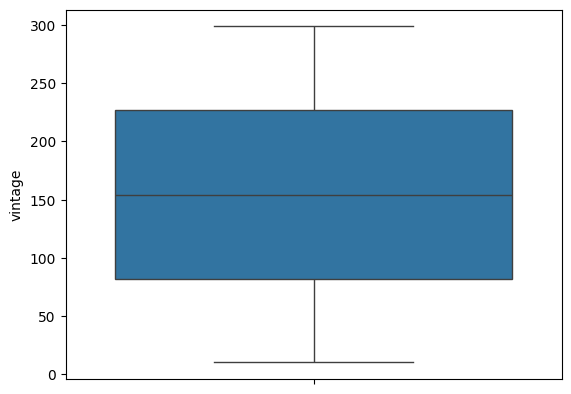

In [36]:
# distribuição vintage
sns.boxplot( df4['vintage'] )


In [37]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
# age
df5_train['age'] = mms_age.fit_transform(df5_train[['age']].values)
pickle.dump( mms_age , open( r'\Users\oscar\Documents\repos\pa004\features_transformation\mms_age.pkl' , 'wb' ) )

# vintage
df5_train['vintage'] = mms_vintage.fit_transform(df5_train[['vintage']].values)
pickle.dump( mms_vintage , open( r'\Users\oscar\Documents\repos\pa004\features_transformation\mms_vintage.pkl', 'wb' ) )

## Encoder

In [38]:
# gender - One Hot Encoding / Target Encoding
target_encoding_gender = df5_train.groupby( 'gender' )['response'].mean()
df5_train.loc[:,'gender'] = df5_train['gender'].map( target_encoding_gender ).astype( 'float64' )
pickle.dump( target_encoding_gender , open( r'\Users\oscar\Documents\repos\pa004\features_transformation\target_encoding_gender.pkl', 'wb' ) )

# region code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_enconding_region_code = df5_train.groupby('region_code')['response'].mean()
df5_train.loc[:,'region_code'] = df5_train['region_code'].map( target_enconding_region_code )
pickle.dump( target_enconding_region_code, open( r'\Users\oscar\Documents\repos\pa004\features_transformation\target_enconding_region_code.pkl' , 'wb' ) )

# vehicle_age
df5_train = pd.get_dummies( data = df5_train, prefix = 'vehicle_age', columns = ['vehicle_age']  )

# policy_sales_channel
fe_policy_sales_channel = df5_train['policy_sales_channel'].value_counts( normalize = True )
df5_train.loc[:, 'policy_sales_channel'] = df5_train['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel , open( r'\Users\oscar\Documents\repos\pa004\features_transformation\fe_policy_sales_channel.pkl' , 'wb' ) )

In [39]:
def encoding( df ):
    
    main_path = r'C:\Users\oscar\Documents\repos\pa004\features_transformation'
    
    encoder_annual_premium = pickle.load( open( os.path.join( main_path, 'annual_premium_scaler.pkl' ) , 'rb' ) )
    encoder_age            = pickle.load( open( os.path.join( main_path, 'mms_age.pkl'),  'rb' ) )
    encoder_vintage        = pickle.load( open( os.path.join( main_path, 'mms_vintage.pkl' ), 'rb' ) )
    encoder_gender         = pickle.load( open( os.path.join( main_path, 'target_encoding_gender.pkl' ), 'rb' ) )
    encoder_region_code    = pickle.load( open( os.path.join( main_path, 'target_enconding_region_code.pkl' ), 'rb' ) )
    encoder_policy_sales   = pickle.load( open( os.path.join( main_path, 'fe_policy_sales_channel.pkl' ) , 'rb' ) )
                                         
    # annual_premium - aplico pois o range é muito amplo
    df['annual_premium'] = encoder_annual_premium.transform( df[['annual_premium']].values )

    # age
    df['age'] = encoder_age.fit_transform( df[['age']].values )

    # vintage
    df['vintage'] = encoder_vintage.fit_transform( df[['vintage']].values )

    # gender - One Hot Encoding / Target Encoding
    df.loc[:,'gender'] = df['gender'].map( target_encoding_gender ).astype( 'float64' )

    # region code - Frequency Encoding / Target Encoding / Weighted Target Encoding
    df.loc[:,'region_code'] = df['region_code'].map( target_enconding_region_code )
    
    # vehicle_age
    df = pd.get_dummies( data = df, prefix = 'vehicle_age', columns = ['vehicle_age']  )

    # policy_sales_channel
    df.loc[:, 'policy_sales_channel'] = df['policy_sales_channel'].map( fe_policy_sales_channel )
    
    df = df.fillna( 0 )
    
    return df

    

In [40]:
df_test = encoding( df5_test )

C:\Users\oscar\AppData\Local\Temp\ipykernel_8128\668323217.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna( 0 )


# 6.0 Feature Selection

In [41]:
df6 = df5.copy()

## 6.1 Training a RF to choose which columns I'll use

In [42]:
# df train
x_train = df5_train.drop( 'response', axis =1 )
y_train = df5_train['response']

# df test
x_test = df_test.drop( 'response', axis = 1 )
y_test = df_test['response']

## 6.2 Feature Importance

In [43]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators = 250 , random_state = 0 , n_jobs = -1 )

# data preparation
x_train_n = x_train.drop(['id'], axis = 1)
y_train_n = y_train.values
forest.fit( x_train_n , y_train_n  )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

feature ranking
                         feature  importance
0                        vintage    0.271927
0                 annual_premium    0.241040
0                            age    0.166972
0                    region_code    0.106600
0                 vehicle_damage    0.067091
0           policy_sales_channel    0.060309
0             previously_insured    0.057638
0       vehicle_age_below_1_year    0.014294
0  vehicle_age_between_1_2_years    0.006350
0                         gender    0.004971
0       vehicle_age_over_2_years    0.002289
0                driving_license    0.000519


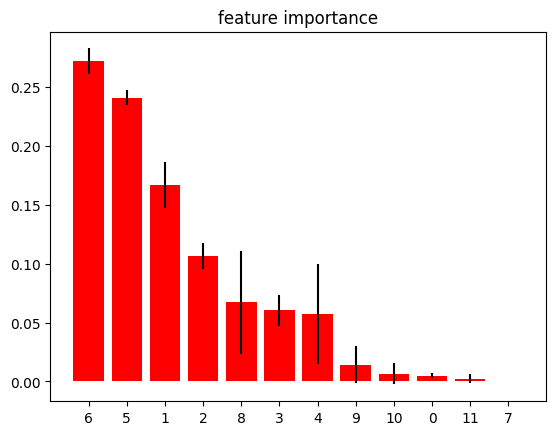

In [44]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis = 0 )
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('feature ranking')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature' : i , 'importance' : j } , index = [0]  )
    df = pd.concat( [df , aux] , axis = 0 )
    
print(df.sort_values('importance', ascending = False) )
      
# Plot the impurity-based feature importance of the forest
plt.figure()
plt.title( 'feature importance' )
plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim( [-1,x_train_n.shape[1]] )
plt.show()



# 7.0 Machine Learning 

In [45]:
# columns selections based on the rf
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'policy_sales_channel',
                 'previously_insured']

x_train = x_train[cols_selected]
x_test = x_test[cols_selected]

## 7.1 Machine Learning 

In [46]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors = 7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_test )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

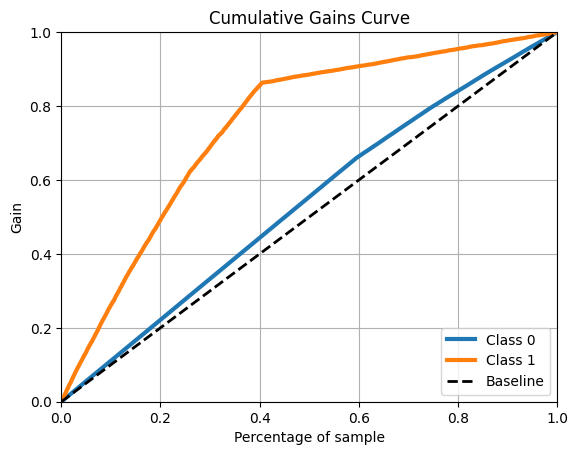

In [47]:
# acumulative gain
skplt.metrics.plot_cumulative_gain( y_test , yhat_knn )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

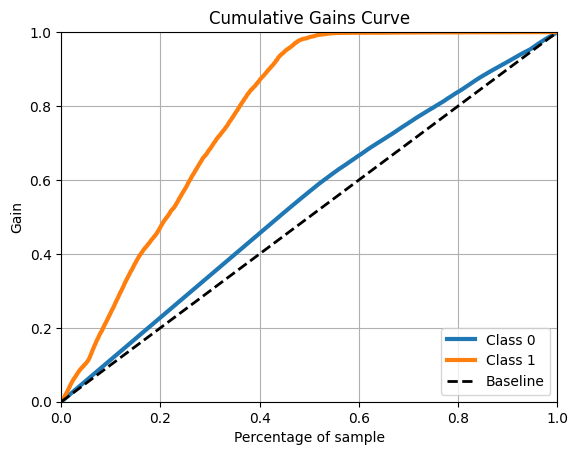

In [48]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_test )

# acumulative gain
skplt.metrics.plot_cumulative_gain( y_test , yhat_lr )

# 7.2 ROC Curve Calculation

In [49]:
# pego as métricas para calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, yhat_lr[:,1])

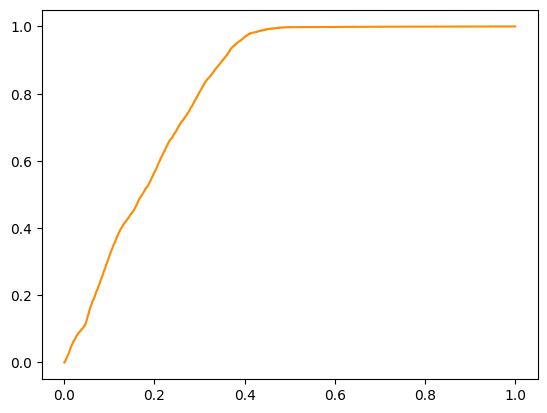

In [50]:
# plotando a curva
plt.plot( fpr , tpr , color = 'darkorange' )


## 8.0 Model Performance 

In [51]:
def precicion_at_k( data , k = 2000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create index
    data['ranking'] = data.index + 1

    # create columns precision score
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[ k, 'precision_at_k' ]


In [52]:
def recall( data , k = 2000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create index
    data['ranking'] = data.index + 1

    # create columns precision score
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[ k, 'recall_at_k' ]


In [53]:
# copy data
df8 = x_test.copy()
df8['response'] = y_test.copy()

# propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending = False ).reset_index(  )

# precicion_at_k
precision = precicion_at_k( df8, k = 50 )
print( 'Precision at K {}'.format( precision ) )

# recall at k
recall = recall( df8 , k = 50 )
print( 'Recall at k {}'.format( recall ) )

Precision at K 0.23529411764705882
Recall at k 0.0008514261387824606


## 9.0 - Deploy to Production

In [54]:
# save trained model
pickle.dump( lr_model, open( r'\Users\oscar\Documents\repos\pa004\models\model_linear_regression.pkl' , 'wb' ) )

In [55]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path                    =  r'\Users\oscar\Documents\repos\pa004\features_transformation'
        self.annual_premium_scaler        = pickle.load( open( self.home_path + '\annual_premium_scaler.pkl' )  )
        self.fe_policy_sales_channel      = pickle.load( open( self.home_path + '\fe_policy_sales_channel.pkl' ) ) 
        self.mms_age                      = pickle.load( open( self.home_path + '\mms_age.pkl' ) )
        self.mms_vintage                  = pickle.load( open( self.home_path + '\mms_vintage.pkl' ) )
        self.target_encoding_gender       = pickle.load( open( self.home_path + '\target_encoding_gender.pkl' ) )
        self.target_enconding_region_code = pickle.load( open( self.home_path + '\target_enconding_region_code') )
        
    def feature_engineering( df2 ):
        # vehicle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                        if x == '1-2 Year' else 'below_1_year')
        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x : 1 if x == 'Yes' else 0 )
        
        return df2
        
    def data_prepatation( self, df5 ):
    
        # annual premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # age
        df5['age'] = self.mms_age.transform(df5[['age']].values)

        # vintage
        df5['vintage'] = self.mms_vintage.transform(df5[['vintage']].values)

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:,'gender'] = df5['gender'].map( self.target_encoding_gender  )

        # region code - Frequency Encoding / Target Encoding / Weighted Target Encoding
        df5.loc[:,'region_code'] = df5['region_code'].map( self.target_enconding_region_code )

        # vehicle_age
        df5 = pd.get_dummies( data = df5, prefix = 'vehicle_age', columns = ['vehicle_age']  )

        # policy_sales_channel

        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )

        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )[:,1]
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.tojson( orient = 'records' , date_format = 'iso' )
        

## 9.2 - API Handler

In [56]:
# import pickle
# import pandas as pd
# from flask import Flask, request, Response
# from modules.healthinsurance import HealthInsurance 

# # loading model
# model = pickle.load( open( 'models/model_linear_regression.pkl', 'rb' ) )

# # initlize API
# app = Flask( __name__ )

# @app.route( '/predict', methods = ['POST'] )
# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         if isinstance( test_json , dict ):
            
#             test_raw = pd.DataFrame( test_json , index = [0] )
#         else:
#             test_raw = pd.DataFrame( test_json , columns = test_json[0].keys() )
            
#         # Initialize Rossmann Class
#         pipeline = HealthInsurance()
        
#         # feature engineering
#         df1 = pipeline.feature_engineering( test_raw )
        
#         # data preparation
#         df2 = pipeline.data_prepatation( df1 )
        
#         # get prediction
#         df_response = pipeline.get_prediction( model, test_raw , df2 )
        
#         return df_response
    
#     else:
        
#         return Response( '{}', status = 200 , mimetype = 'application/json' )
    
# if __name__ == '__main__':
    
#     app.run( '0.0.0.0', debug = True , use_reloader=False)
        


## 9.3 - API Tester

In [57]:
import requests

In [58]:
# loading test dataset
df_test = x_test
df_test['response'] = y_test

In [59]:
# pego uma amostra
df_test = df_test.sample( 10 )

In [60]:
df_test.to_csv( 'pa004.csv' )

In [61]:
# convert into dict
data = json.dumps( df_test.to_dict( orient = 'records' ) )

In [62]:
url = 'https://healthinsurace.lm.r.appspot.com/predict'
header = { 'Content-type' : 'application/json' }

r = requests.post( url = url , data = data , headers = header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 500


In [63]:
d1 = pd.DataFrame( r.json() , columns = r.json()[0].keys() )
d1.sort_values( by = 'prediction' , ascending = False )

JSONDecodeError: Expecting value: line 2 column 1 (char 1)